<h1 align='center'> CE1015 Project - FS3 Group 3 </h1>

### Presented by
Brandon
<br>Kenny
<br>Sabrina
<br>Snehaa




## Import Essential Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold


In [2]:
listings = pd.read_csv("listings.csv")
listings.info()

FileNotFoundError: [Errno 2] File listings.csv does not exist: 'listings.csv'

In [ ]:
calendar = pd.read_csv("calendar.csv")
calendar.head()

<h1 align='center'> Data Cleaning  </h1>


### Drop the colums that is useless and missing a lot of data

In [6]:
#finding the variables with high number of 'NaN' input values
listings.isna().sum().sort_values(ascending = False).head(15)

NameError: name 'listings' is not defined

In [7]:
listings = pd.read_csv("https://raw.githubusercontent.com/brandonywl/cz1015-miniproject/master/listings.csv")
variables = [var for var in listings]

#exclude host characteristics, administratives like URL and ID which will not gain us more insight to the data, and variables which information are already represented by other variables.
variables_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',\
                     'host_url', 'host_name', 'host_id', 'host_since', 'host_location', 'host_about', 'host_response_time', 'name',\
                     'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit'] 

variables_to_drop += ["host_acceptance_rate", "host_is_superhost", "country", "country_code", "smart_location", "state", "city", \
                      "host_thumbnail_url", "host_picture_url", "host_verifications", "host_has_profile_pic", "host_identity_verified",\
                      "neighbourhood_cleansed", "neighbourhood", "market", 'host_neighbourhood', 'host_response_rate', 'host_listings_count', \
                      'host_total_listings_count', 'street']

variables_to_drop += ["is_location_exact", "bed_type", "extra_people", "minimum_nights", "maximum_nights", \
                      "calendar_updated", 'has_availability']

variables_to_drop += ["calendar_last_scraped", "first_review", "last_review","jurisdiction_names", "requires_license", "license", \
                      "availability_60", "availability_90"]

variables_to_drop += ["square_feet"]


for var in variables_to_drop:
    try:
      variables.remove(var)
    except:
      pass

listings = pd.DataFrame(listings[variables])

listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   neighbourhood_group_cleansed      3818 non-null   object 
 2   zipcode                           3811 non-null   object 
 3   latitude                          3818 non-null   float64
 4   longitude                         3818 non-null   float64
 5   property_type                     3817 non-null   object 
 6   room_type                         3818 non-null   object 
 7   accommodates                      3818 non-null   int64  
 8   bathrooms                         3802 non-null   float64
 9   bedrooms                          3812 non-null   float64
 10  beds                              3817 non-null   float64
 11  amenities                         3818 non-null   object 
 12  price 

In [8]:
listings.isna().sum().sort_values(ascending = False).head(15)

monthly_price                  2301
security_deposit               1952
weekly_price                   1809
cleaning_fee                   1030
review_scores_accuracy          658
review_scores_checkin           658
review_scores_value             656
review_scores_location          655
review_scores_cleanliness       653
review_scores_communication     651
review_scores_rating            647
reviews_per_month               627
bathrooms                        16
zipcode                           7
bedrooms                          6
dtype: int64

### Numerical related variable

In [9]:
cleaned_data = listings.copy()

# Convert the price, weekly price and monthly price from string to float 
prices = ["price", "weekly_price", "monthly_price", "security_deposit", "cleaning_fee"]
for price in prices:
  cleaned_data[price] = cleaned_data[price].str.replace("$","")
  cleaned_data[price] = cleaned_data[price].str.replace(",","")
  cleaned_data[price] = cleaned_data[price].astype("float64")

# Assuming no entry means no reviews
cleaned_data["reviews_per_month"].fillna(value = 0, inplace = True)

# Isolate all the review_scores and fill in empty reviews with the median, assuming that no review means people deem it to be normal
review_scores = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', \
                 'review_scores_checkin', 'review_scores_communication', 'review_scores_communication', \
                 'review_scores_location', 'review_scores_value']

for review in review_scores:
  cleaned_data[review].fillna(value = cleaned_data[review].median(), inplace = True)

# Assume that empty entries == no special price. Hence weekly price = price * 7 and monthly price = price * 31
empty_prices = ["weekly_price", "monthly_price"]
days = [7,31]
count = 0
for price in empty_prices:
  cleaned_data[price].fillna(value = cleaned_data['price'] * days[count], inplace = True)
  count += 1

# Assume that empty entries == No security deposit and no cleaning fees
empty_prices = ['security_deposit', 'cleaning_fee']
for price in empty_prices:
  cleaned_data[price].fillna(value = 0, inplace = True)

# As some accomodations have 4.5 toilets, we are going to assume that an empty entry == there are no toilets in the apartment. Same goes for
# beds and bedrooms
# This can be the scenario where they only rent the apartment, hence no access to the toilet
# Or they rent a boat and does not count as a bedroom / bed
rooms = ['bathrooms', 'bedrooms', 'beds']
for room in rooms:
  cleaned_data[room].fillna(value = 0, inplace = True)


# We will be classifying the only entry with no property_type under 'Other'
cleaned_data['property_type'].fillna(value = 'Other', inplace = True)


# Isolate all the categorical data as they are the only ones with type object
categorical_data = ['instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', \
                    'require_guest_phone_verification', 'neighbourhood_group_cleansed', \
                    'property_type', 'room_type']
for data in categorical_data:
  # Convert data type to category
  cleaned_data[data] = cleaned_data[data].astype('category')



cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   id                                3818 non-null   int64   
 1   neighbourhood_group_cleansed      3818 non-null   category
 2   zipcode                           3811 non-null   object  
 3   latitude                          3818 non-null   float64 
 4   longitude                         3818 non-null   float64 
 5   property_type                     3818 non-null   category
 6   room_type                         3818 non-null   category
 7   accommodates                      3818 non-null   int64   
 8   bathrooms                         3818 non-null   float64 
 9   bedrooms                          3818 non-null   float64 
 10  beds                              3818 non-null   float64 
 11  amenities                         3818 non-null   object

### Property Type

In [10]:
cleaned_data.property_type.value_counts()

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                23
Cabin                21
Camper/RV            13
Bungalow             13
Boat                  8
Tent                  5
Treehouse             3
Dorm                  2
Chalet                2
Yurt                  1
Name: property_type, dtype: int64

In [11]:
# Replacing categories that are types of houses or apartments
cleaned_data.property_type.replace({
    'Townhouse': 'House',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Chalet': 'House'  
    }, inplace=True)

# Replacing other categories with 'other'
cleaned_data.loc[~cleaned_data.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'
cleaned_data.property_type.value_counts()

House        1866
Apartment    1748
Other         204
Name: property_type, dtype: int64

### Amenities

In [12]:
# change the object to str
amenities=cleaned_data["amenities"].astype("str")
#join the data by "," and split the long string into a wordlist by ","
amenities=','.join(amenities)
word_list=amenities.split(sep=",")

new_wordlist=[]
#clean the data
for word in word_list:
    word=word.replace("}","")
    word=word.replace("{","")
    word=word.replace("\"","")
    new_wordlist.append(word)
    
#convert to a series and count the unique amenities
word_series=pd.Series(new_wordlist)
len(word_series.unique())


42

In [13]:
word_series.value_counts()

Wireless Internet             3667
Heating                       3627
Kitchen                       3423
Smoke Detector                3281
Essentials                    3237
Dryer                         2997
Washer                        2992
Internet                      2811
Shampoo                       2670
TV                            2574
Carbon Monoxide Detector      2485
Fire Extinguisher             2196
Free Parking on Premises      2167
Family/Kid Friendly           1963
First Aid Kit                 1680
Cable TV                      1446
Indoor Fireplace               886
Pets live on this property     883
Hangers                        846
Elevator in Building           785
Hair Dryer                     774
Laptop Friendly Workspace      745
Iron                           742
Safety Card                    727
Air Conditioning               677
24-Hour Check-in               616
Buzzer/Wireless Intercom       538
Dog(s)                         509
Pets Allowed        

### Choosing the amenitites that might be useful to determine the price
I'll ignore amenities that is over 3000 because most of the listing have it. Also, the amenities that contain less than 400

Dryer/ washer 

TV / Cable TV

Free_Parking on Premises

Family/Kid Friendly

Pets live on this property /Pets Allowed /Dog(s) / Cat(s)

Elevator in Building

Safety Card 

Air Conditioning

24-Hour Check-in

Gym

In [14]:
cleaned_data.loc[cleaned_data['amenities'].str.contains('Dryer|Washer'), 'Laundry'] = 1
cleaned_data.loc[cleaned_data['amenities'].str.contains('TV|"Cable TV'), 'TV'] = 1
cleaned_data.loc[cleaned_data['amenities'].str.contains('Free Parking on Premises'), 'Parking'] = 1
cleaned_data.loc[cleaned_data['amenities'].str.contains('Family/Kid Friendly'), 'Family_friendly'] = 1
cleaned_data.loc[cleaned_data['amenities'].str.contains('Pets live on this property|Pets Allowed|Cat(s)|Dog(s)'), 'Pets_friendly'] = 1
cleaned_data.loc[cleaned_data['amenities'].str.contains('Elevator in Building'), 'Elevator'] = 1
cleaned_data.loc[cleaned_data['amenities'].str.contains('Safety Card'), 'Security'] = 1
cleaned_data.loc[cleaned_data['amenities'].str.contains('Air Conditioning'), 'Air_conditioning'] = 1
cleaned_data.loc[cleaned_data['amenities'].str.contains('24-Hour Check-in'), '24-Hour_Check-in'] = 1
cleaned_data.loc[cleaned_data['amenities'].str.contains('Gym'), 'Gym'] = 1


C:\Users\kenny\Anaconda3\lib\site-packages\pandas\core\strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [15]:
# Replacing nulls with zeros for new columns
amenities_cols = ["Laundry","TV","Parking","Family_friendly","Pets_friendly","Elevator","Security","Air_conditioning","24-Hour_Check-in","Gym"]
cleaned_data[amenities_cols] = cleaned_data[amenities_cols].fillna(0)

# Dropping amenities
cleaned_data.drop('amenities', axis=1, inplace=True)


In [16]:
cleaned_data[amenities_cols]

,Laundry,TV,Parking,Family_friendly,Pets_friendly,Elevator,Security,Air_conditioning,24-Hour_Check-in,Gym
0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3813,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3814,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3815,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3816,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


<h1 align='center'> Exploratory Analysis  </h1>


[Text(0, 0.5, 'price'),
 Text(0, 1.5, 'weekly_price'),
 Text(0, 2.5, 'monthly_price'),
 Text(0, 3.5, 'accommodates'),
 Text(0, 4.5, 'bedrooms'),
 Text(0, 5.5, 'beds'),
 Text(0, 6.5, 'cleaning_fee'),
 Text(0, 7.5, 'bathrooms'),
 Text(0, 8.5, 'guests_included'),
 Text(0, 9.5, 'security_deposit')]

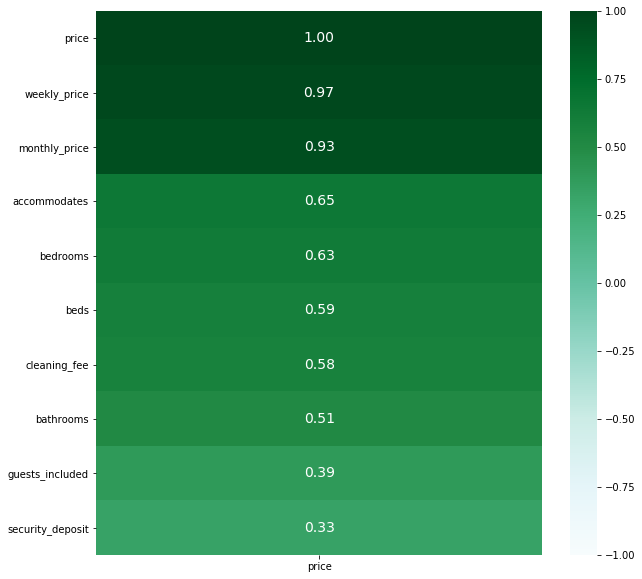

In [84]:
#heatmap to show the corealation between variables, to see which variables have the strongest relationship
f, axes = plt.subplots(1,1, figsize = (10,10))

cor_target = abs(cleaned_data.drop(amenities_cols,axis=1).corr()["price"])
features = cor_target[cor_target>0.3].sort_values(ascending=False)
features

hm=sb.heatmap(features.to_frame(),annot = True, fmt = ".2f", annot_kws = {"size": 14},
           vmin = -1, vmax = 1, cmap = 'BuGn')
#Correlation with output variable
hm.set_yticklabels(hm.get_yticklabels(),rotation=0)




#threshhold 0.75 and above:
#bedrooms & accommodates = 0.77
#beds & accomodates = 0.86
#bedrooms & beds = 0.75
#monthly_price & price = 0.93
#weekly_price & monthly_price = 0.95
#price & weekly_price = 0.97

 ### How does number of accomodates affect the price?

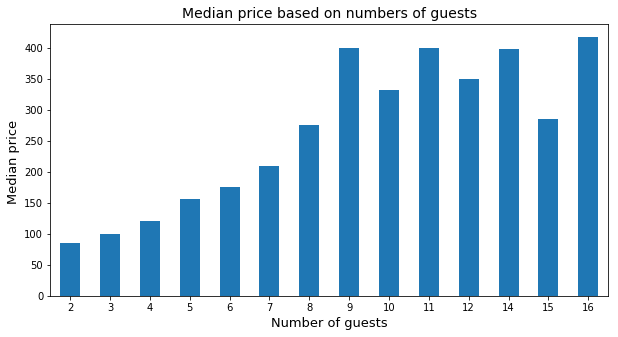

In [0]:
plt.figure(figsize=(10,5))
cleaned_data.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price based on numbers of guests', fontsize=14)
plt.xlabel('Number of guests', fontsize=13)
plt.ylabel('Median price ', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

Strong linear relationship between median price and number of guests.

### How neigbourhood affect the price?

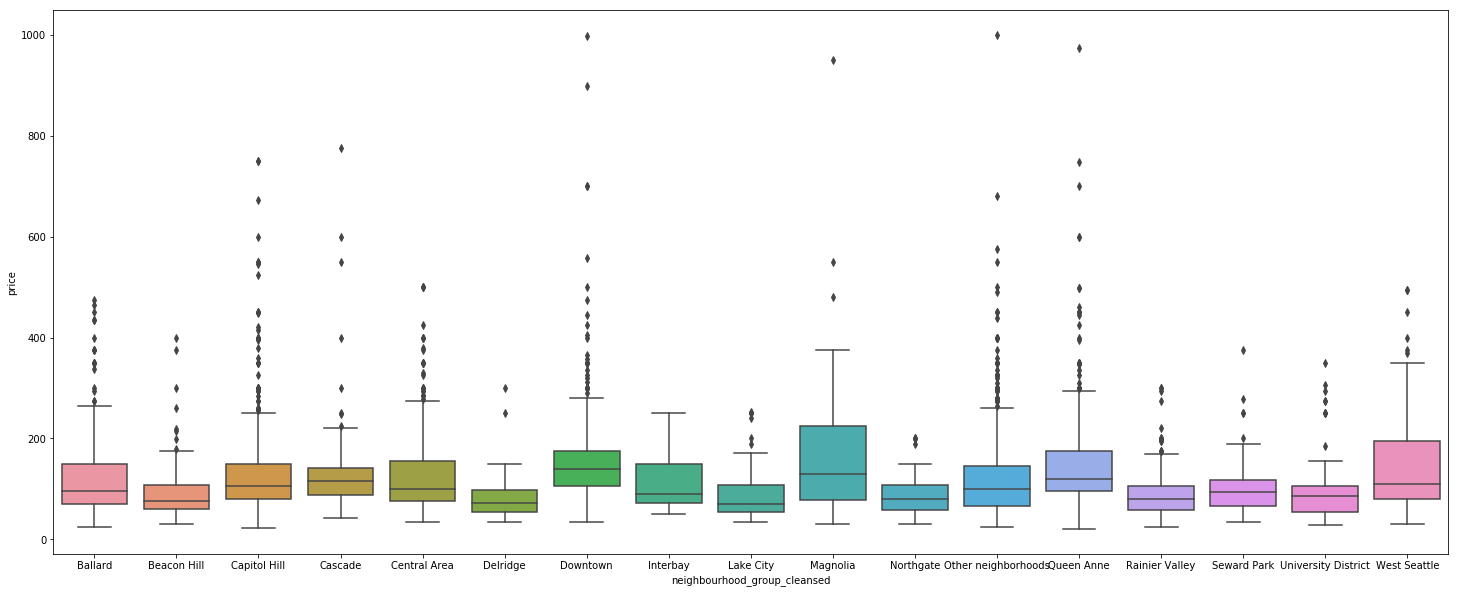

In [0]:
plt.figure(figsize=(25,10))
# visualise it in boxplot
sb.boxplot(x=cleaned_data.neighbourhood_group_cleansed,y=cleaned_data.price)

In [0]:
#get the mean of the neighbourhood_group_cleansed
cleaned_data.groupby('neighbourhood_group_cleansed').size()

neigh_group = pd.DataFrame(cleaned_data.groupby('neighbourhood_group_cleansed').size())
neigh_group.rename(columns={0: 'number_of_listings'}, inplace=True)
neigh_group['median_price'] = cleaned_data.groupby('neighbourhood_group_cleansed').price.median().values

In [0]:
neigh_group['median_price'].sort_values(ascending = False)

neighbourhood_group_cleansed
Downtown               139.0
Magnolia               129.0
Queen Anne             119.0
Cascade                115.0
West Seattle           109.0
Capitol Hill           105.0
Central Area           100.0
Other neighborhoods     99.0
Ballard                 95.0
Seward Park             93.0
Interbay                90.0
University District     85.0
Rainier Valley          80.0
Northgate               79.5
Beacon Hill             75.0
Delridge                72.0
Lake City               70.0
Name: median_price, dtype: float64

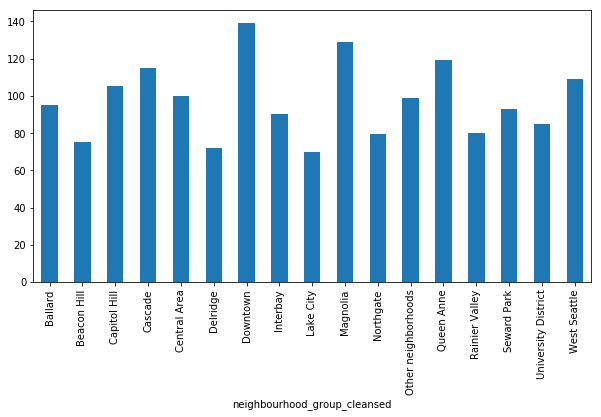

In [0]:
plt.figure(figsize=(10,5))
cleaned_data.groupby('neighbourhood_group_cleansed').price.median().plot(kind="bar")
plt.show()

In [0]:
neigh_group.index

CategoricalIndex(['Ballard', 'Beacon Hill', 'Capitol Hill', 'Cascade',
                  'Central Area', 'Delridge', 'Downtown', 'Interbay',
                  'Lake City', 'Magnolia', 'Northgate', 'Other neighborhoods',
                  'Queen Anne', 'Rainier Valley', 'Seward Park',
                  'University District', 'West Seattle'],
                 categories=['Ballard', 'Beacon Hill', 'Capitol Hill', 'Cascade', 'Central Area', 'Delridge', 'Downtown', 'Interbay', ...], ordered=False, name='neighbourhood_group_cleansed', dtype='category')

In [0]:
import geopandas as gpd
import adjustText as aT

map_df = gpd.read_file('neighborhoods.geojson')
len(map_df.nhood.unique())

85

In [0]:
map_diff = map_df[map_df['nhood'].isin(neigh_group.index)]

In [0]:
len(map_diff.nhood.unique())

16

In [0]:
seatle_map_df = map_diff.set_index('nhood').join(neigh_group)


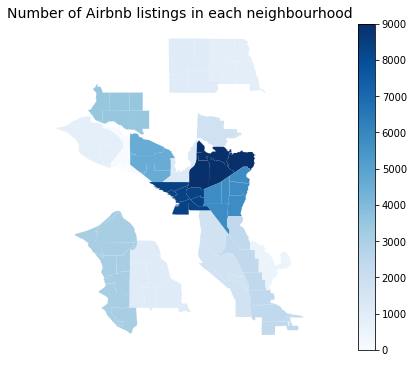

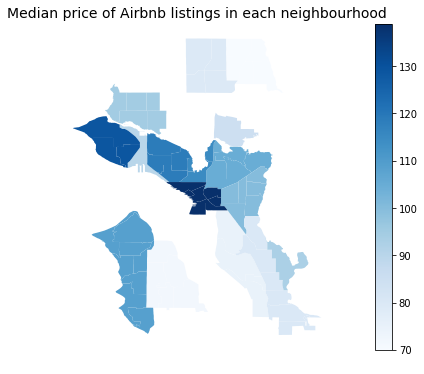

In [0]:
# Plotting the number of listings in each neighbourhood
fig1, ax1 = plt.subplots(1,figsize=(15, 6))
seatle_map_df.plot(column='number_of_listings', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each neighbourhood', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each neighbourhood
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
seatle_map_df.plot(markersize=14,column='median_price', cmap='Blues', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each neighbourhood', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(seatle_map_df.median_price), vmax=max(seatle_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)



plt.show()

Generally, if there is lesser listings, the price is higher, with the exception of the region in the middle (West Seattle). (inverse relationship)

## How amenitites affect Price

In [0]:
def binary_count_and_price_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    cleaned_data.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    cleaned_data.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price')
    ax2.set_xlabel('')
    
    plt.show()

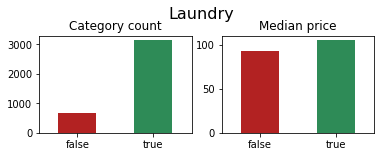

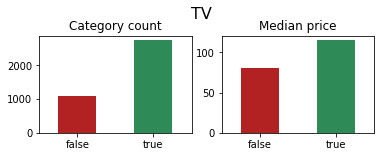

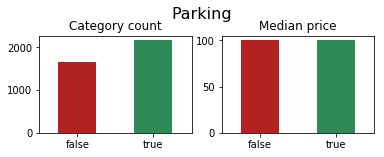

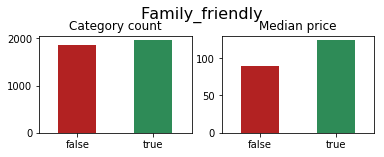

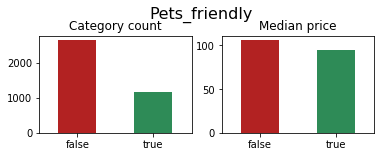

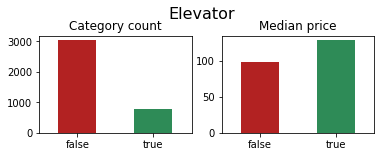

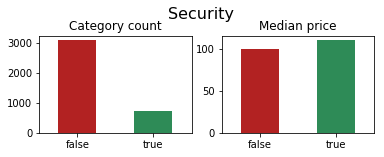

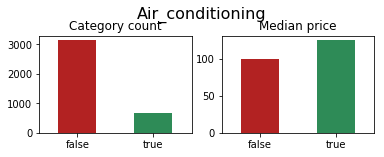

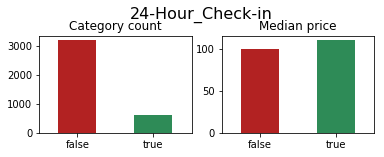

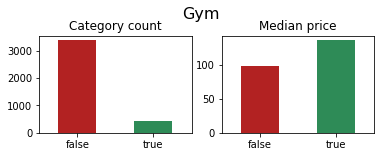

In [0]:
for col in cleaned_data[amenities_cols]:
    binary_count_and_price_plot(col, figsize=(6,2))

Typically, the inclusion of an amenity raises the price of an apartment expect for pets friendly, security, elevator, 24/7 checkin. The inclusion of these amenities do not raise the price.

<h1 align='center'> Data preparation for Linear regression  </h1>


In [0]:
cleaned_data.columns

Index(['id', 'neighbourhood_group_cleansed', 'zipcode', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'price', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'guests_included',
       'availability_30', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month', 'Laundry', 'TV',
       'Parking', 'Family_friendly', 'Pets_friendly', 'Elevator', 'Security',
       'Air_conditioning', '24-Hour_Check-in', 'Gym'],
      dtype='object')

In [0]:
regression_variables = ['price',"guests_included", 'neighbourhood_group_cleansed', 'property_type', 'room_type','security_deposit', 'cleaning_fee', 'accommodates', 'bathrooms', 'bedrooms', 'beds']
amenities_cols = ["Laundry","TV","Parking","Family_friendly","Pets_friendly","Elevator","Security","Air_conditioning","24-Hour_Check-in","Gym"]

regression_data = cleaned_data[regression_variables+amenities_cols]

regression_data

,price,guests_included,neighbourhood_group_cleansed,property_type,room_type,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,...,Laundry,TV,Parking,Family_friendly,Pets_friendly,Elevator,Security,Air_conditioning,24-Hour_Check-in,Gym
0,85.0,2,Queen Anne,Apartment,Entire home/apt,0.0,0.0,4,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,150.0,1,Queen Anne,Apartment,Entire home/apt,100.0,40.0,4,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,975.0,10,Queen Anne,House,Entire home/apt,1000.0,300.0,11,4.5,5.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,100.0,1,Queen Anne,Apartment,Entire home/apt,0.0,0.0,3,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,450.0,6,Queen Anne,House,Entire home/apt,700.0,125.0,6,2.0,3.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,359.0,1,Other neighborhoods,House,Entire home/apt,0.0,230.0,6,2.0,3.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3814,79.0,3,Capitol Hill,Apartment,Entire home/apt,500.0,50.0,4,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3815,93.0,2,Rainier Valley,House,Entire home/apt,250.0,35.0,2,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3816,99.0,1,Capitol Hill,Other,Entire home/apt,300.0,45.0,2,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [0]:
#transform neighbourhood_group_cleansed, room_type and property_type from categorical variables to binary variables for easier comparison with price.
transformed_df = pd.get_dummies(regression_data)
transformed_df

,price,guests_included,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,Laundry,TV,...,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,property_type_Apartment,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,85.0,2,0.0,0.0,4,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,1,0,0,1,0,0
1,150.0,1,100.0,40.0,4,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,1,0,0,1,0,0
2,975.0,10,1000.0,300.0,11,4.5,5.0,7.0,1.0,1.0,...,0,0,0,0,0,1,0,1,0,0
3,100.0,1,0.0,0.0,3,1.0,0.0,2.0,1.0,0.0,...,0,0,0,0,1,0,0,1,0,0
4,450.0,6,700.0,125.0,6,2.0,3.0,3.0,0.0,1.0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,359.0,1,0.0,230.0,6,2.0,3.0,3.0,1.0,1.0,...,0,0,0,0,0,1,0,1,0,0
3814,79.0,3,500.0,50.0,4,1.0,1.0,2.0,1.0,1.0,...,0,0,0,0,1,0,0,1,0,0
3815,93.0,2,250.0,35.0,2,1.0,1.0,1.0,1.0,1.0,...,1,0,0,0,0,1,0,1,0,0
3816,99.0,1,300.0,45.0,2,1.0,0.0,1.0,1.0,1.0,...,0,0,0,0,0,0,1,1,0,0


### Standardising and normalising



In [0]:

numerical_columns = ['accommodates', 'bathrooms', "bedrooms","beds","guests_included",'cleaning_fee', 'price', 'security_deposit']

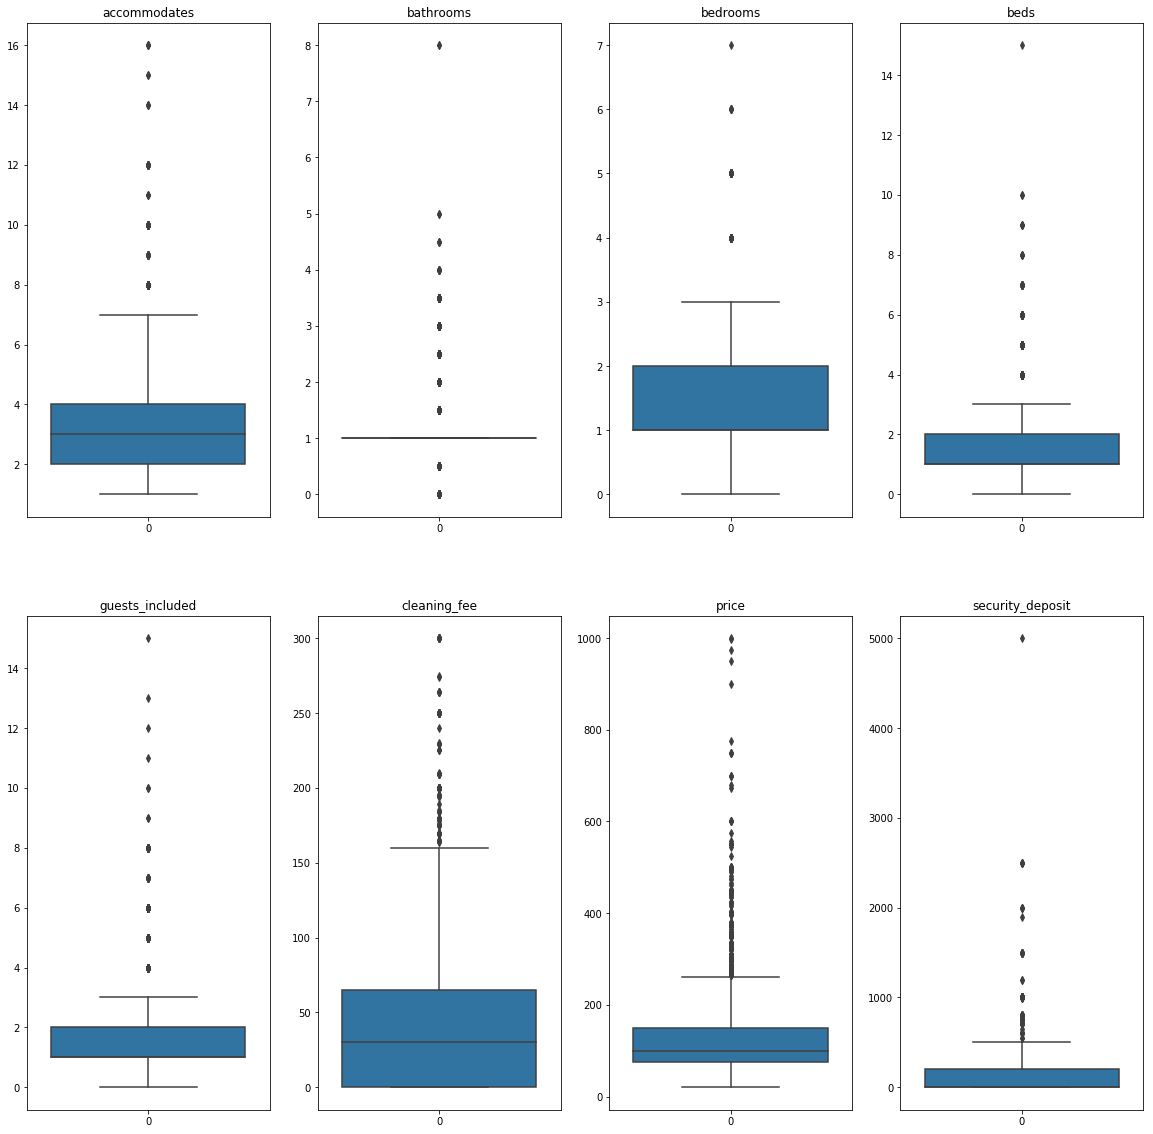

In [0]:
f,axes=plt.subplots(2,4,figsize=(20,20))
r=0
c=0
for am in numerical_columns:
    axes[r][c].set_title(am)
    sb.boxplot(data=transformed_df[am], ax=axes[r][c])
    c+=1
    if(c==4): 
        r=1 
        c=0


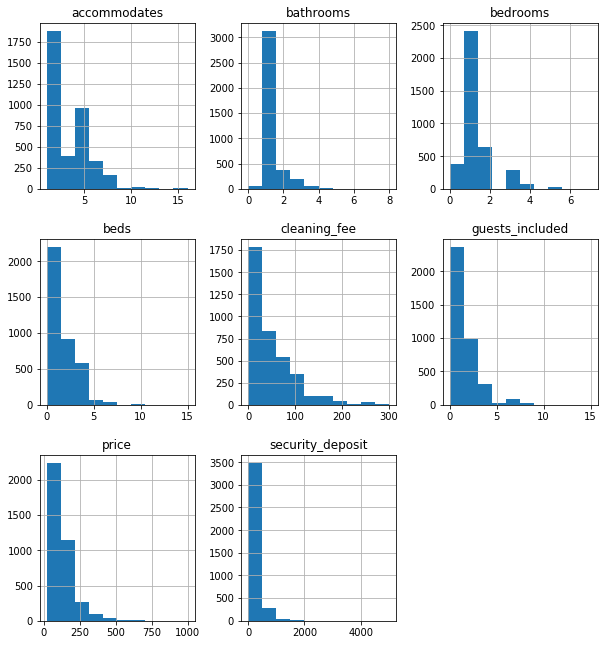

In [0]:
transformed_df[numerical_columns].hist(figsize=(10,11));


In [0]:
# Log transforming columns
#numerical_columns = [i for i in numerical_columns ] # Removing items not to be transformed
#numerical_columns=["price"]
for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64')
    transformed_df[col] = np.log(transformed_df[col]+1)
def normalize(column):
    upper=column.max()
    lower=column.min()
    y=(column-lower)/(upper-lower)
    return y
#normalize(transformed_df[numerical_columns])

Log transform makes highly skewed data less skewed, and this makes pattern in the data more interpretable.

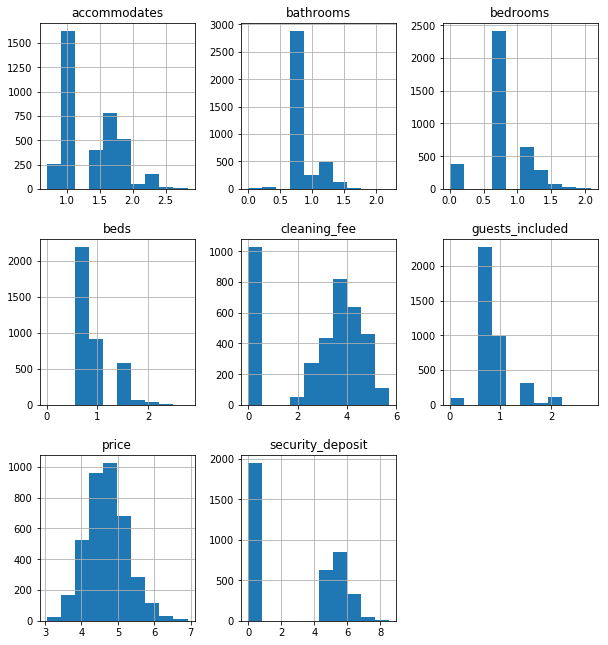

In [0]:
transformed_df[numerical_columns].hist(figsize=(10,11));
# Scaling


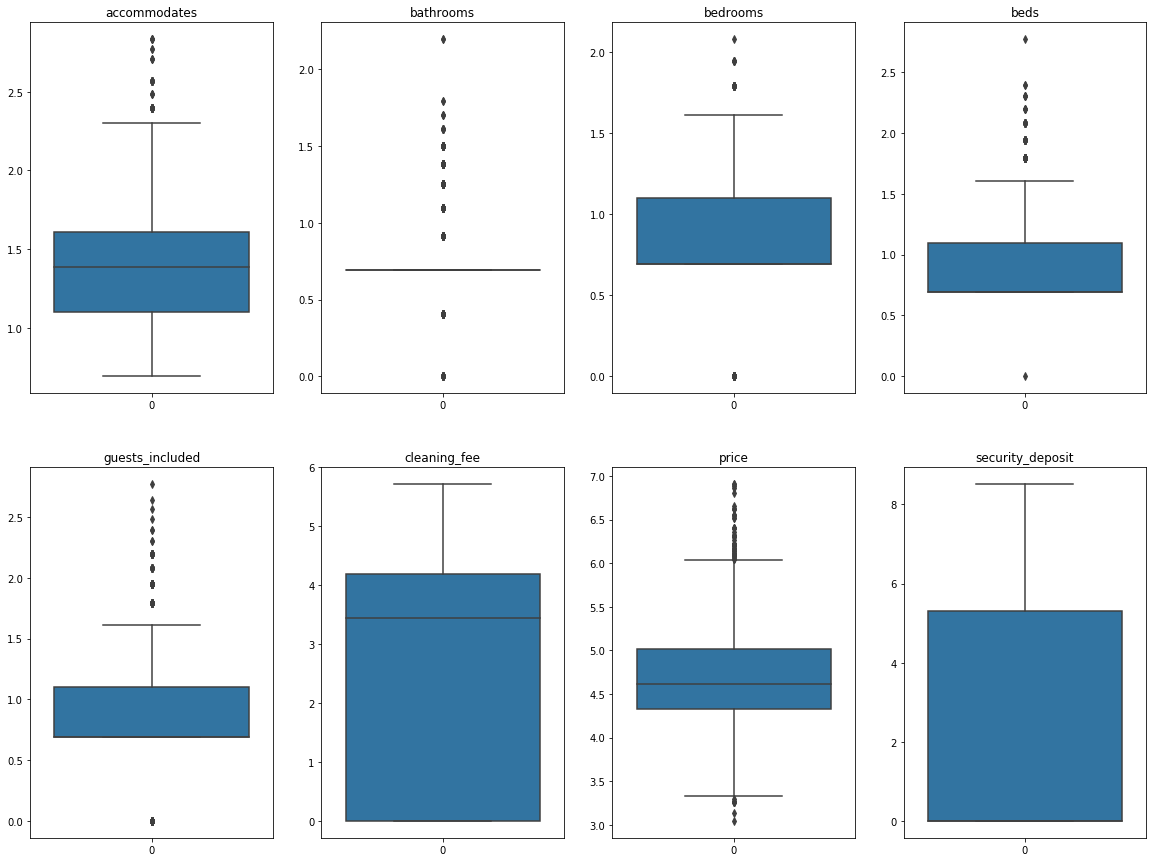

In [0]:
f,axes=plt.subplots(2,4,figsize=(20,15))
r=0
c=0
for am in numerical_columns:
    axes[r][c].set_title(am)
    sb.boxplot(data=transformed_df[am], ax=axes[r][c])
    c+=1
    if(c==4): 
        r=1 
        c=0


We reduced the number of outliers and make the data more inclusive. 

<h1 align='center'> Problem1 : Predicting price using Linear Regression  </h1>


# Split into test train set

In [0]:

# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))
#pd.DataFrame(X, columns=list(X.columns))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [0]:
transformed_df.to_csv("linear_regression_data.csv")

# Various Linear regression Algorithm

## Ordinary least squares Linear Regression.

Intercept of Regression 	: b =  4.695243791730657
Coefficients of Regression 	: a =  [ 2.65479484e-02  4.47851030e-03  7.56545392e-03  1.27031880e-01
  7.31515322e-02  1.16766572e-01  1.07038956e-02 -9.48030412e-03
  1.44018607e-02 -1.22224095e-02 -8.54145322e-03 -7.04355999e-03
  2.84406995e-02  7.31522498e-03  4.24594124e-03 -3.39647951e-02
  1.17987824e-03  2.00689508e+10  1.45974299e+10  2.99940110e+10
  1.27269907e+10  2.49226554e+10  1.20067595e+10  2.91634146e+10
  4.52087307e+09  1.10750442e+10  1.05759660e+10  1.20808968e+10
  3.42322683e+10  2.25217360e+10  1.68505585e+10  9.00247282e+09
  1.48347568e+10  1.89250355e+10  3.58846288e+10  3.60037965e+10
  1.61980125e+10  3.34790872e+11  3.26349018e+11  1.22300519e+11]



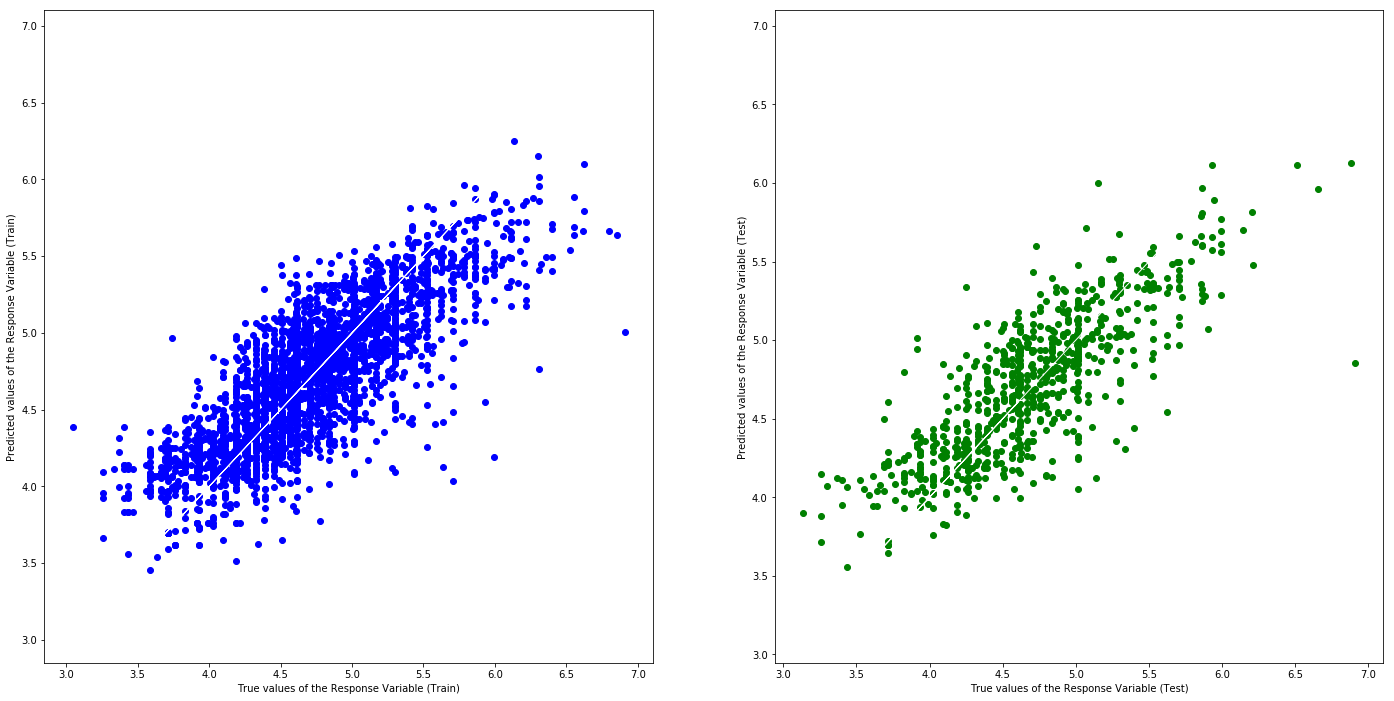

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.6572409505261056
Mean Squared Error (MSE) 	: 0.10739273948369762

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.6477516894650436
Mean Squared Error (MSE) 	: 0.11067370117453844


In [0]:
# Import essential models and functions from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()


# Predict Response corresponding to Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))


R^2 for both Train and Test Data are similar, and thus the results from the Train is quite accurate.

## XGBRegressor
XGBoost stands for eXtreme Gradient Boosting
<br>XGBoost is an algorithm that has recently been dominating applied machine learning and Kaggle competitions for structured or tabular data.
<br>The XGBoost library implements the gradient boosting decision tree algorithm.



Training MSE: 0.0846
Validation MSE: 0.1005

Training r2: 0.7299
Validation r2: 0.68


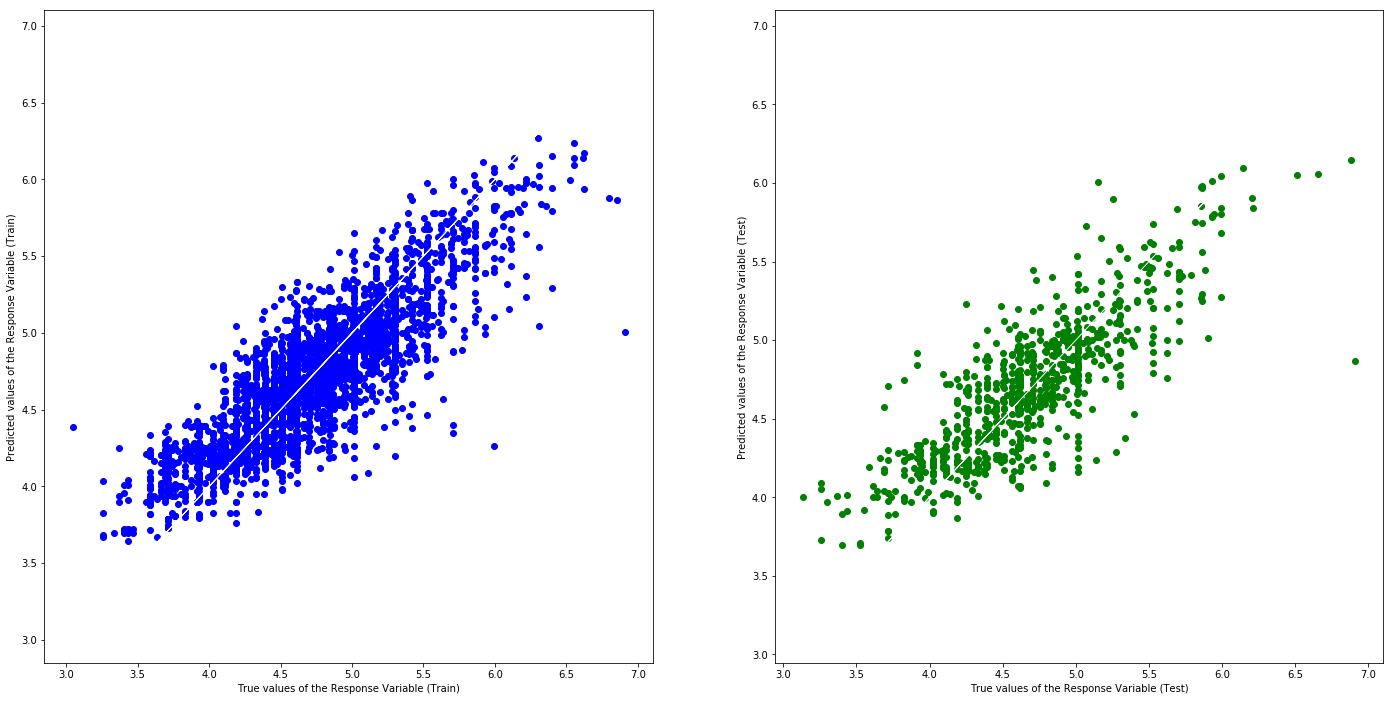

In [0]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

xgb_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)


print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, training_preds_xgb_reg, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, val_preds_xgb_reg, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [0]:
scores = cross_val_score(xgb_reg, X_train,y_train,cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgb_reg, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

Mean cross-validation score: 0.68
K-fold CV average score: 0.69


In [0]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg.head(20)

,weight
neighbourhood_group_cleansed_Ballard,0.000000
neighbourhood_group_cleansed_Interbay,0.000000
neighbourhood_group_cleansed_Central Area,0.000000
Laundry,0.002534
Parking,0.002587
Pets_friendly,0.002976
beds,0.003057
Family_friendly,0.003251
neighbourhood_group_cleansed_Lake City,0.003626
neighbourhood_group_cleansed_West Seattle,0.003889


In [0]:
ft_weights_xgb_reg.sort_values(ascending=False,by=["weight"]).head(10).index

Index(['room_type_Entire home/apt', 'bedrooms', 'bathrooms', 'accommodates',
       'cleaning_fee', 'neighbourhood_group_cleansed_Downtown', 'Elevator',
       'neighbourhood_group_cleansed_Capitol Hill', 'property_type_House',
       'neighbourhood_group_cleansed_Queen Anne'],
      dtype='object')

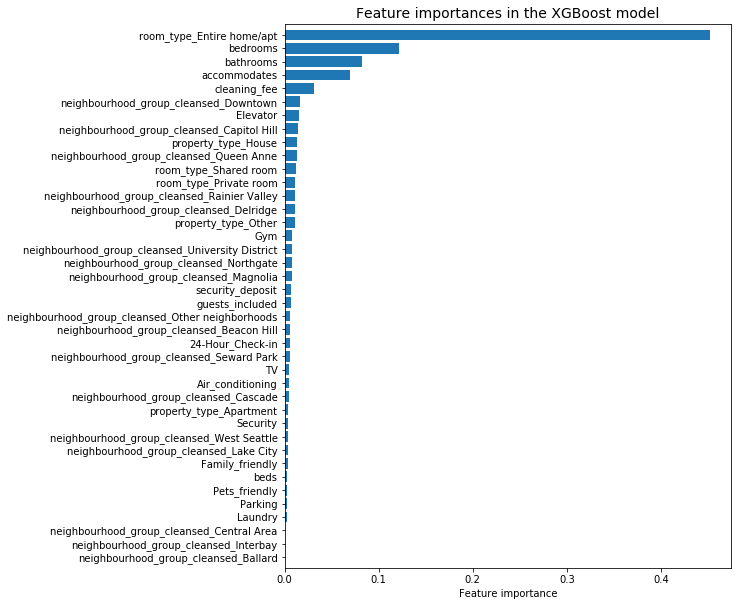

In [0]:
# Plotting feature importances
plt.figure(figsize=(8,10))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()


From XGBoost model, room_type_Entire home/apt, bedrooms, bathrooms, accomodates and cleaning_fee plays an important role when it comes to the pricing of the AirBnB.

## Random Forest
A Random Forest is an ensemble technique capable of performing both regression and classification tasks with the use of multiple decision trees and a technique called Bootstrap Aggregation

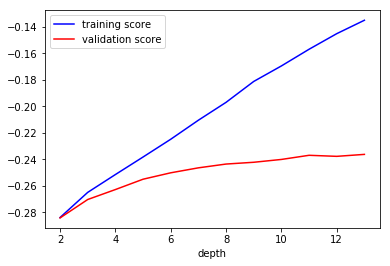

In [0]:
from sklearn.model_selection import validation_curve
model = RandomForestRegressor(n_estimators=100)
depth = [2, 3, 4,5,6,7,8,9,10,11,12,13]#try thisvariety of parameters for model
train_score, val_score = validation_curve(
 model, X_train, y_train,
 param_name='max_depth', param_range=depth, 
scoring='neg_mean_absolute_error', cv=3)
plt.plot(depth, np.median(train_score, 1), color='blue', label='training score')
plt.plot(depth, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('depth');


Training MSE: 0.0527
Validation MSE: 0.0986

Training r2: 0.8318
Validation r2: 0.6863


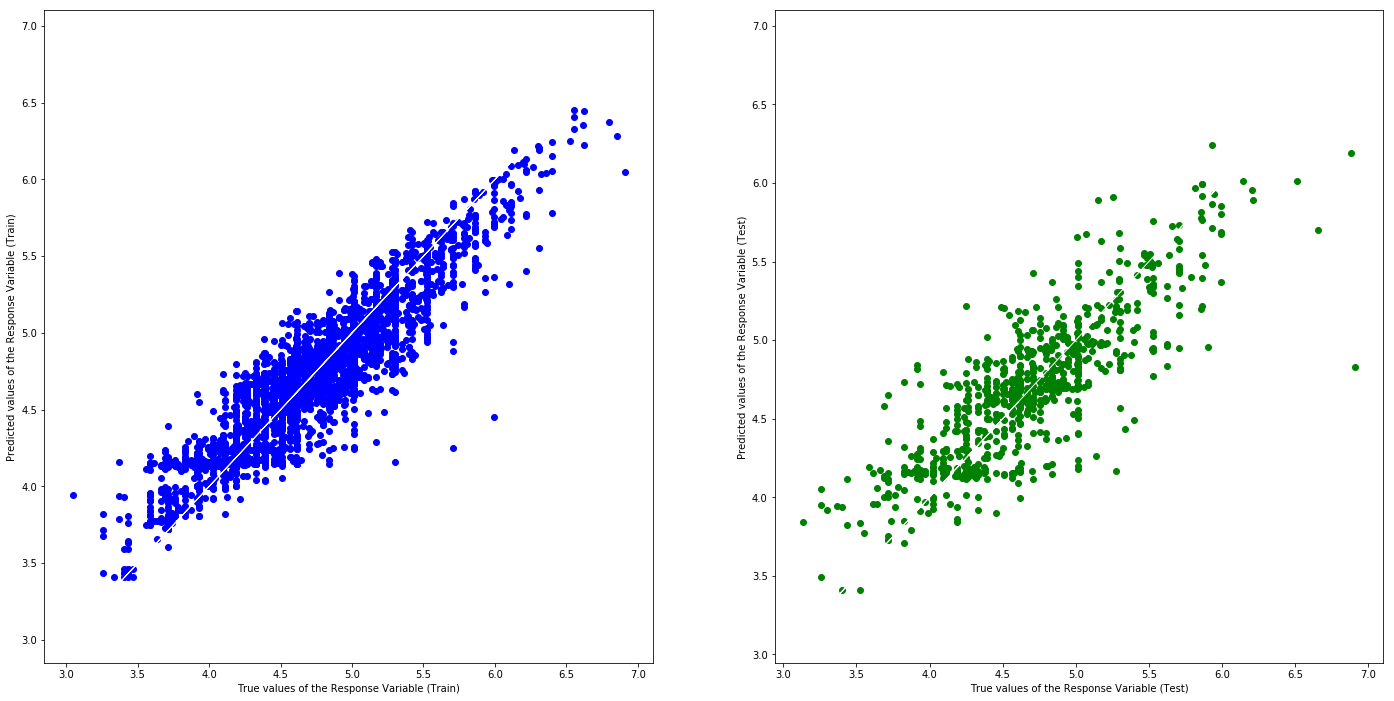

In [0]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=500, 
                               max_depth=10,
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print("\nTraining MSE:", round(mean_squared_error(y_train, y_train_pred),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Neural Network using tensorflow 2.0
<br> We have done the test on the google collab 
<br> The following consist of the link to the collab

In [0]:
https://colab.research.google.com/drive/1S387BnwqN186zjZhi4wLhQS8MQoI487E

<h1 align='center'> Problem2 : Selling Points for apartments of different price points </h1>


In [0]:
# Import KMeans from sklearn.cluster
from sklearn.cluster import KMeans

clustering_variables = ['id', 'price', 'cleaning_fee', \
                        'accommodates', 'bathrooms', \
                        'bedrooms', 'beds']
clustering_data = pd.DataFrame(cleaned_data[clustering_variables])
clustering_data.head()

,id,price,cleaning_fee,accommodates,bathrooms,bedrooms,beds
0,241032,85.0,0.0,4,1.0,1.0,1.0
1,953595,150.0,40.0,4,1.0,1.0,1.0
2,3308979,975.0,300.0,11,4.5,5.0,7.0
3,7421966,100.0,0.0,3,1.0,0.0,2.0
4,278830,450.0,125.0,6,2.0,3.0,3.0


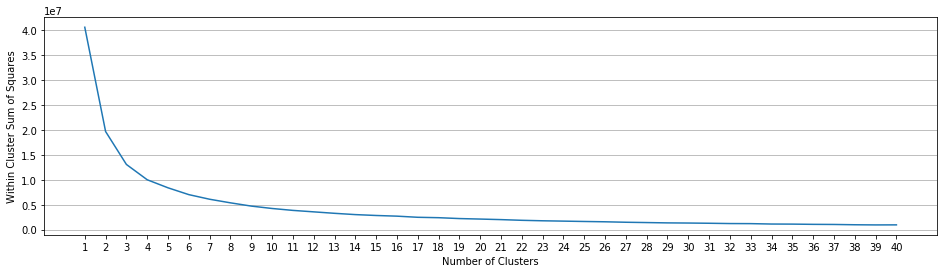

In [0]:
'''
Code obtained from M5 Clustering from Prof Sourav
'''

temp_clustering = clustering_data.iloc[:, 1:]
ids = pd.DataFrame(clustering_data.iloc[:, 0])

# Vary the Number of Clusters
min_clust = 1
max_clust = 40
init_algo = 'k-means++'

# Compute Within Cluster Sum of Squares
within_ss = []
for num_clust in range(min_clust, max_clust+1):
    kmeans = KMeans(n_clusters = num_clust, init = init_algo, n_init = 5)
    kmeans.fit(temp_clustering)
    within_ss.append(kmeans.inertia_)

# Angle Plot : Within SS vs Number of Clusters
f, axes = plt.subplots(1, 1, figsize=(16,4))
plt.plot(range(min_clust, max_clust+1), within_ss)
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.xticks(np.arange(min_clust, max_clust+1, 1.0))
plt.grid(which='major', axis='y')
plt.show()

In [0]:
# Set "optimal" Clustering Parameters
num_clust = 8
init_algo = 'k-means++'

# Create Clustering Model using KMeans
kmeans = KMeans(n_clusters = num_clust,         
               init = init_algo,
               n_init = 20)                 

# Fit the Clustering Model on the Data
kmeans.fit(temp_clustering)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=20, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Features 	Price 	Fees 	Accom. 	WCs 	Rooms 	Beds

Cluster 0:	69.38	11.01	2.17	1.11	0.93	1.19	
Cluster 1:	262.62	197.4	6.92	2.3	2.98	3.8	
Cluster 2:	152.53	20.98	3.32	1.17	1.23	1.62	
Cluster 3:	165.06	99.66	4.85	1.42	1.84	2.49	
Cluster 4:	807.14	167.36	8.43	2.79	3.5	4.5	
Cluster 5:	454.92	150.0	7.85	2.66	3.53	4.27	
Cluster 6:	101.44	56.66	3.2	1.07	1.04	1.58	
Cluster 7:	274.9	72.91	5.56	1.79	2.35	2.86	

Within Cluster Sum of Squares : 5269310.231154915



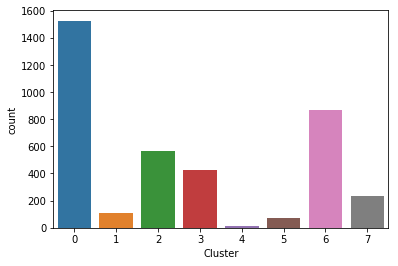

In [0]:
# Print the Cluster Centers
print("Features", "\tPrice", "\tFees", "\tAccom.", "\tWCs", "\tRooms", "\tBeds")
print()

for i, center in enumerate(kmeans.cluster_centers_):
    print("Cluster", i, end=":\t")
    for coord in center:
        print(round(coord, 2), end="\t")
    print()
print()

# Print the Within Cluster Sum of Squares
print("Within Cluster Sum of Squares :", kmeans.inertia_)
print()

# Predict the Cluster Labels
labels = kmeans.predict(temp_clustering)

# Append Labels to the Data
X_labeled = temp_clustering.copy()
X_labeled["Cluster"] = pd.Categorical(labels)

# Summary of the Cluster Labels
sb.countplot(X_labeled["Cluster"])

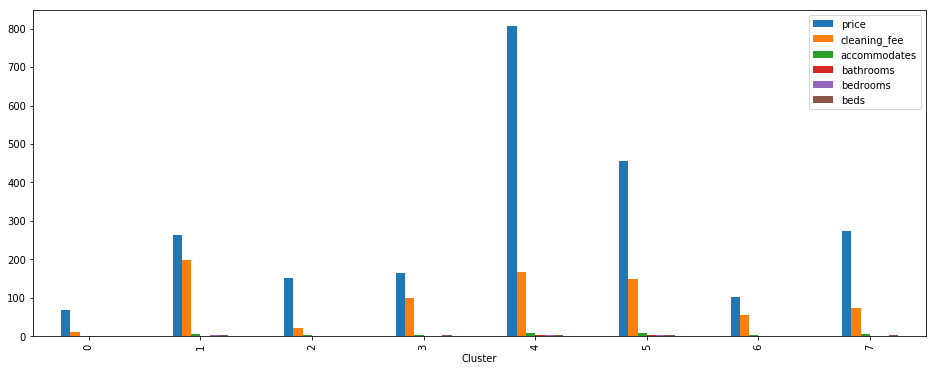

In [0]:
# Average Behaviour of each Cluster
cluster_data = pd.DataFrame(X_labeled.groupby(by = "Cluster").mean())
cluster_data.plot.bar(figsize = (16,6))

In [0]:
clustering_data = pd.concat([ids, X_labeled.reindex(index = ids.index)], axis = 1, sort = False)
clustering_data

,id,price,cleaning_fee,accommodates,bathrooms,bedrooms,beds,Cluster
0,241032,85.0,0.0,4,1.0,1.0,1.0,0
1,953595,150.0,40.0,4,1.0,1.0,1.0,2
2,3308979,975.0,300.0,11,4.5,5.0,7.0,4
3,7421966,100.0,0.0,3,1.0,0.0,2.0,0
4,278830,450.0,125.0,6,2.0,3.0,3.0,5
...,...,...,...,...,...,...,...,...
3813,8101950,359.0,230.0,6,2.0,3.0,3.0,1
3814,8902327,79.0,50.0,4,1.0,1.0,2.0,6
3815,10267360,93.0,35.0,2,1.0,1.0,1.0,6
3816,9604740,99.0,45.0,2,1.0,0.0,1.0,6


In [0]:
reviews_data = pd.read_csv("https://raw.githubusercontent.com/brandonywl/cz1015-miniproject/master/reviews.csv", \
                      usecols = ["listing_id", "comments"])
clusternum = 1

subset = pd.DataFrame(clustering_data[clustering_data['Cluster'] == clusternum])
subset_id = subset['id']

reviews = reviews_data[reviews_data.listing_id.isin(subset_id)]
reviews

,listing_id,comments
1335,4251235,We didn't meet the host and all arrangements w...
1336,4251235,"All around, a very good experience, and quite ..."
1337,4251235,Listing description is accurate. The place is...
1338,4251235,Great location. Beautiful view. Lovely apart...
1339,4251235,This was my 5th time visiting Seattle and this...
...,...,...
84307,1984962,"The House is great! Very clean, modern and all..."
84308,1984962,William was extremely communicative during the...
84309,1984962,Great location for exploring Seattle. Very cle...
84310,1984962,The house is very modern and stylish. It has e...


# Using NLP to 

In [0]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

ModuleNotFoundError: No module named 'nltk'

In [0]:
reviews['comments'] = reviews['comments'].astype("str")
reviews['comments'].fillna('Null', inplace = True)
reviews['comments'] = reviews['comments'].str.replace(r'[^\x00-\x7F]+', '')

temp_comments = reviews['comments']
temp_comments = " ".join(temp_comments)
tokens = word_tokenize(temp_comments)
clean_tokens = []
stop_words = stopwords.words('english')

new_stop = ['place', 'stay', 'house', 'highly', 'recommend', 'nice', 'everything', 'needed', '\'s', 'n\'t', 'great', \
            'seattle', 'us', 'host', 'would', 'time', 'apartment', 'easy', 'definitely', 'really', 'also', 'well', \
            'amazing', 'room', 'home', 'made', 'get', 'like', 'even', 'good', 'wonderful', ' could']
new_stop += stop_words
new_stop += list(string.punctuation)

for w in tokens:
    if w.lower() not in new_stop:
        clean_tokens.append(w)

In [0]:
freq = nltk.FreqDist(clean_tokens)
freq.plot(20, cumulative = False)

In [0]:
top_words = [word[0] for word in freq.most_common(19)]
top_words

In [0]:
from IPython.display import display
import ipywidgets as widgets

In [0]:
from IPython.display import display
import ipywidgets as widgets

# Conclusion

# Reference


https://towardsdatascience.com/predicting-airbnb-prices-with-machine-learning-and-deep-learning-f46d44afb8a6
<br >https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/
<br> https://medium.com/datadriveninvestor/random-forest-regression-9871bc9a25eb
<br> https://medium.com/@lily_su/adjusting-parameters-for-scikitlearn-use-case-of-predicting-daily-total-number-of-bicycle-trips-c6cfdec02993